Import libraries, modules, and functions.

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import shapely
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

Generate map classifying zip codes between those that intersect public libraries, and those that do not.

/usr/local/python/3.12.1/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: Several features with id = 1 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


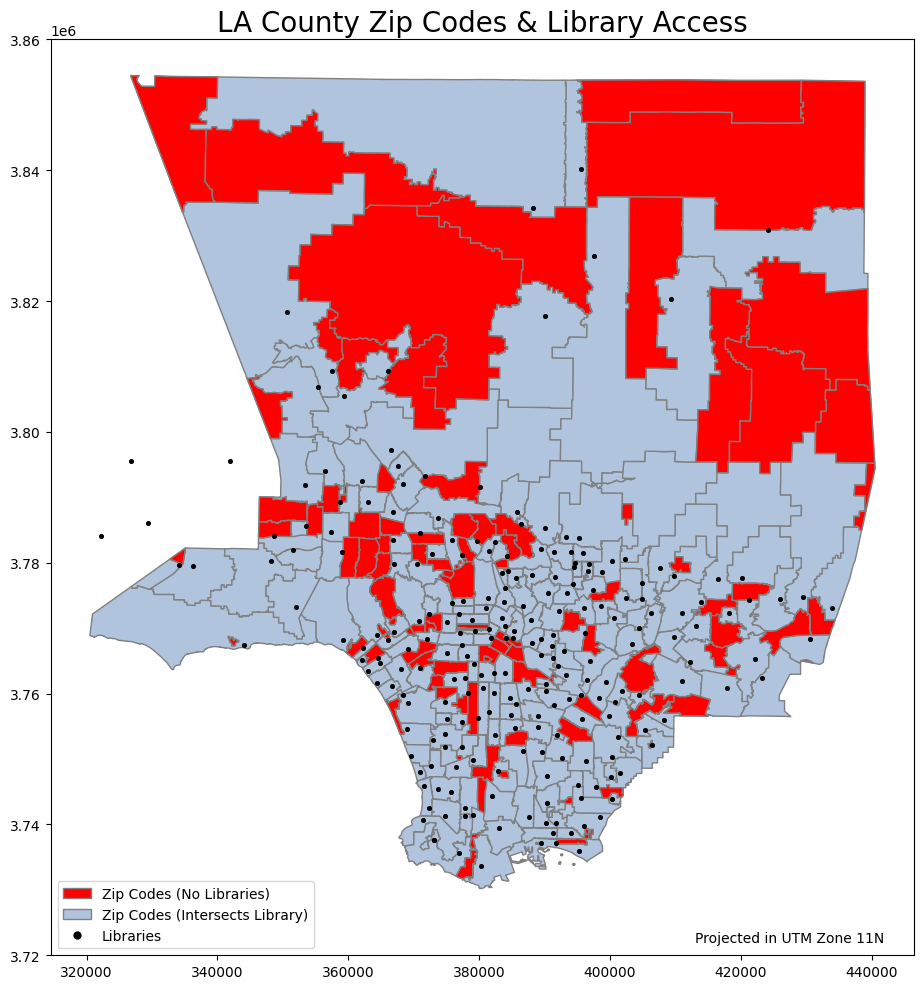

In [ ]:
# Load data & project to UTM zone 11N
libraries = gpd.read_file('LA_County_Public_Libraries.geojson')\
    .to_crs(epsg=26911)
zipcodes = gpd.read_file('LA_County_ZIP_Codes.geojson')\
    .to_crs(epsg=26911)

# Column cleaning for easier joining...
libraries['OBJECTID'] = libraries['ObjectID']
libraries = libraries.drop(columns=['ObjectID'])
libraries.head()

# Join & Filter
zipcodes_leftjoin_libraries = zipcodes.sjoin(
    libraries, predicate='intersects', how='left'
)

zipcodes_no_library = zipcodes_leftjoin_libraries.loc[(zipcodes_leftjoin_libraries['OBJECTID_right'].isnull())]

# Plot
map1 = zipcodes.plot(figsize=(10,10), color='lightsteelblue', edgecolor='grey', linewidth=1)
zipcodes_no_library.plot(ax=map1, color='red', edgecolor='grey', linewidth=1)
libraries.plot(ax=map1, color='black', markersize=7)

# Legend
legend_elements = [
    Patch(facecolor='red', edgecolor='grey', label='Zip Codes (No Libraries)'),
    Patch(facecolor='lightsteelblue', edgecolor='grey', label='Zip Codes (Intersects Library)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=7, label='Libraries')
]

plt.legend(handles=legend_elements, loc='lower left')


plt.ylim(3720000, 3860000) # Cropping out Catalina Island... 
plt.title('LA County Zip Codes & Library Access', fontsize=20)
plt.text(413000, 3722000, 'Projected in UTM Zone 11N')
plt.tight_layout()


Find nearest neighbors for centroids belonging to zip codes that **do not** intersect a public library.
Filter and plot the 20 nearest neighbor pairs that are farthest from eachother.

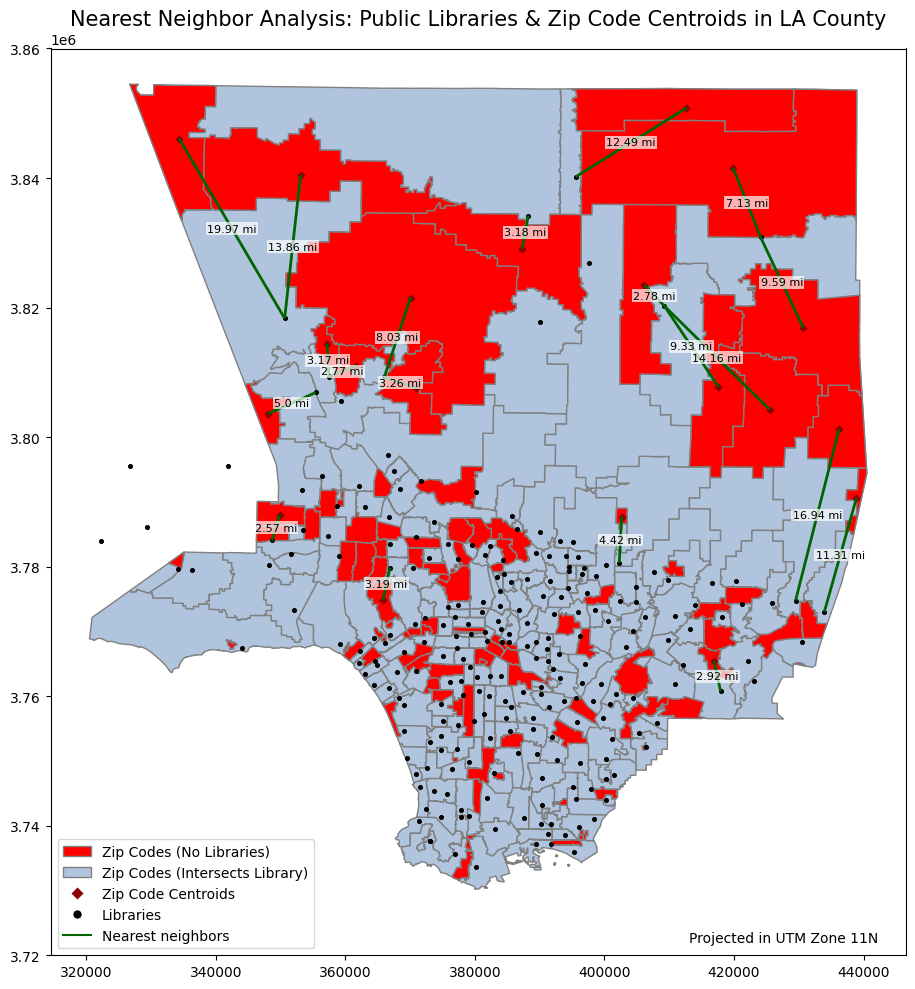

In [2]:
# New geodataframe for centroids of zip codes lacking libraries 
no_library_centroids = gpd.GeoDataFrame(
    geometry=zipcodes_no_library.centroid, crs=zipcodes_no_library.crs
)

# Locate closest libraries to zip code centroids
closest_libraries = no_library_centroids.sjoin_nearest(
    libraries, distance_col='distance_m'
)

# Quick conversion from meters to miles
closest_libraries['distance_mi'] = round((closest_libraries['distance_m'] * 0.00062137),2)

# Merge in the geometry of our library locations using new 'index_right' column
closest_libraries = closest_libraries.merge(
    libraries['geometry'], left_on='index_right', right_index=True
)

closest_libraries.rename(
    columns = {'geometry_x' : 'geometry_zip',
     'geometry_y' : 'geometry_lib'},
    inplace=True)

closest_libraries['geometry_lines'] = closest_libraries.apply(
    lambda row : shapely.LineString([row['geometry_zip'], row['geometry_lib']]), axis=1)

closest_libraries.set_geometry('geometry_lines', inplace=True)

# Plotting the top 20 zip code centroids that are furthest away from a local public library.
library_deserts = closest_libraries.sort_values(by='distance_mi', ascending=False)[0:20]
# Also want to *ONLY* plot those corresponding centroids
active_centroids = library_deserts.copy()
active_centroids.set_geometry('geometry_zip', inplace=True)

# Plot
map2 = zipcodes.plot(figsize=(10,10), color='lightsteelblue', edgecolor='grey', linewidth=1)
zipcodes_no_library.plot(ax=map2, color='red', edgecolor='grey', linewidth=1)
active_centroids.plot(ax=map2, color='darkred', markersize=11, marker='D')
libraries.plot(ax=map2, color='black', markersize=7)
library_deserts.plot(ax=map2, color='darkgreen', lw=2)

# Legend
legend_elements = [
    Patch(facecolor='red', edgecolor='grey', label='Zip Codes (No Libraries)'),
    Patch(facecolor='lightsteelblue', edgecolor='grey', label='Zip Codes (Intersects Library)'),
    Line2D([0], [0], marker='D', color='w', markerfacecolor='darkred', markersize=7, label='Zip Code Centroids'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=7, label='Libraries'),
    Line2D([0], [0], color='darkgreen', label='Nearest neighbors')
]

plt.legend(handles=legend_elements, loc='lower left')
plt.text(413000, 3722000, 'Projected in UTM Zone 11N')

# Annotate distances
for idx, row in library_deserts.iterrows():

    midpoint = row['geometry_lines'].interpolate(0.5, normalized=True)

    map2.annotate(
        f"{row['distance_mi']} mi",
        xy=(midpoint.x, midpoint.y),
        ha='center',
        va='center',
        bbox={
            'facecolor':'white',
            'alpha':0.7,
            'edgecolor':'none',
            'pad':1
            },
        fontsize=8
        )

plt.title('Nearest Neighbor Analysis: Public Libraries & Zip Code Centroids in LA County', fontsize=15)
plt.ylim(3720000, 3860000)
plt.tight_layout()


The figure above primarily draws attention to library deserts in the northern region of Los Angeles County, *which has a ***significantly lower population density*** when compared to the more urbanized, southern counterpart.* The code below utilizes the broader nearest neighbor dataset to measure and plot distances between centroids of zip codes lacking an intersecting public library, and the nearest neighbor. Here, I specifically target zip codes in the Gardena/Torrance area and the Encino/Van Nuys area. These neighborhoods were selected because they contain clusters of zip code polygons that did not meet the intersection criteria.

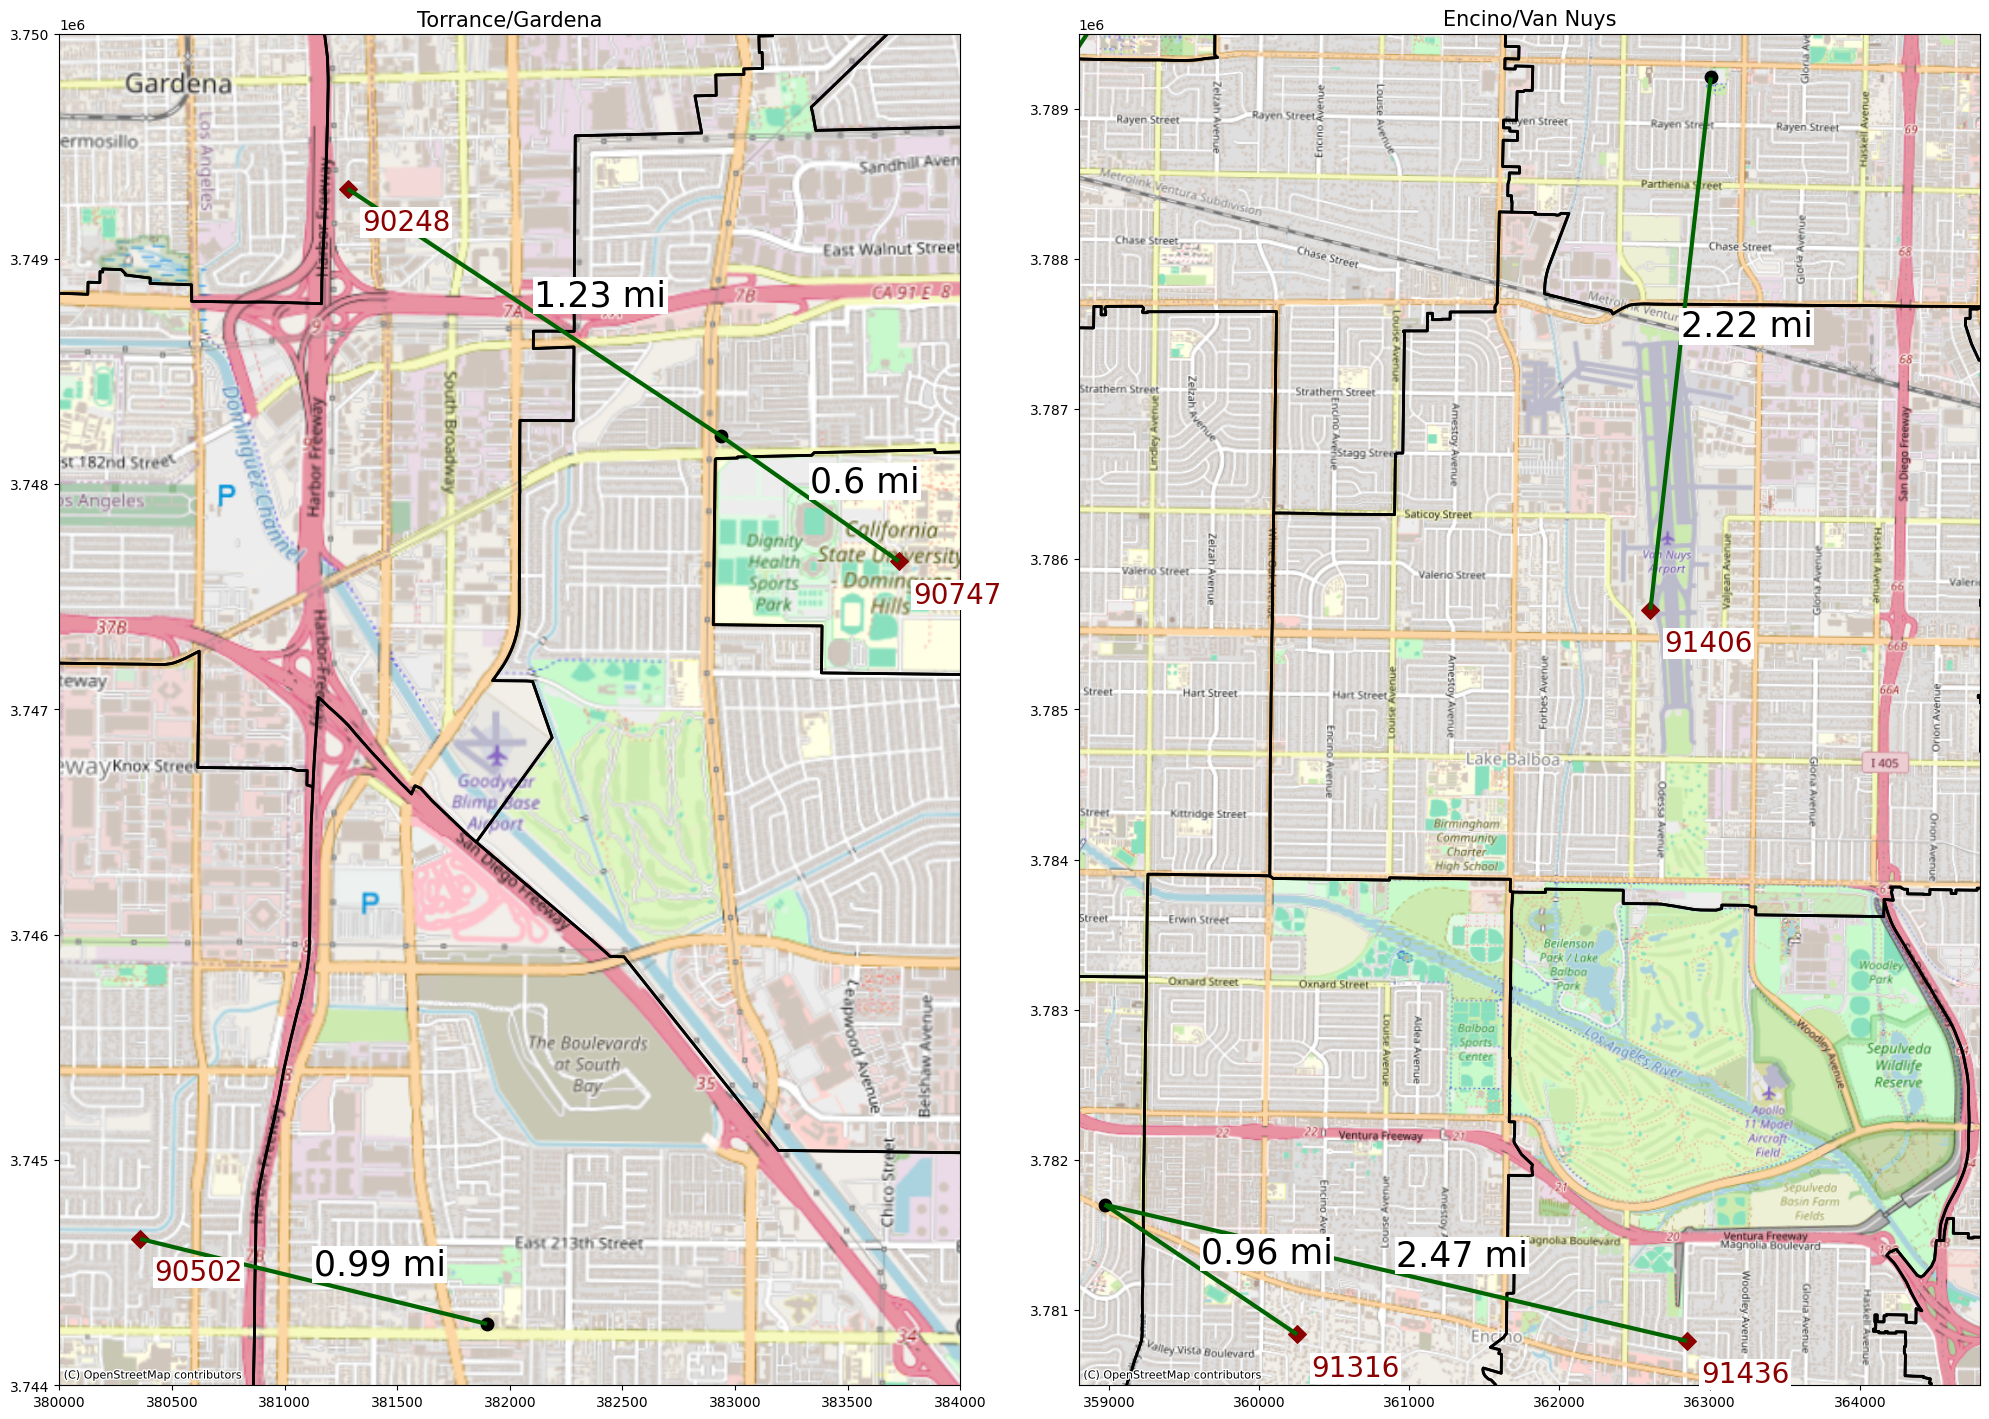

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))

############ LAYOUT 1 ############
zipcodes.plot(ax=ax1, color='none', edgecolor='black', linewidth=2)
libraries.plot(ax=ax1, color='black', markersize=80)
no_library_centroids.plot(ax=ax1, color='darkred', markersize=80, marker='D')
closest_libraries.plot(ax=ax1, color='darkgreen', lw=3)

#print(zipcodes.loc[(zipcodes['ZIPCODE'] == '90248') | \
#                   (zipcodes['ZIPCODE'] == '90502')].total_bounds)
#[ 378783.80223348 3741734.99889103  383269.04321813 3753634.66992262]
ax1.set_xlim(380000, 384000)
ax1.set_ylim(3744000, 3750000)
ax1.set_title('Torrance/Gardena', fontsize=15)

############ LAYOUT 2 ############
zipcodes.plot(ax=ax2, color='none', edgecolor='black', linewidth=2)
libraries.plot(ax=ax2, color='black', markersize=80)
no_library_centroids.plot(ax=ax2, color='darkred', markersize=80, marker='D')
closest_libraries.plot(ax=ax2, color='darkgreen', lw=3)
no_library_centroids.plot(ax=ax2, color='none', edgecolor='none') # For annotation purposes.

#print(zipcodes.loc[(zipcodes['ZIPCODE'] == '91406') | (zipcodes['ZIPCODE'] == '91316')\
#                   | (zipcodes['ZIPCODE'] == '91436')].total_bounds)
# [ 358649.90646637 3777604.90236372  364921.12141148 3788313.0304547 ]
ax2.set_xlim(358800, 364800)
ax2.set_ylim(3780500, 3789500)
ax2.set_title('Encino/Van Nuys', fontsize=15)

############ ANNOTATIONS & BASEMAPS ############
for idx, row in closest_libraries.iterrows(): # Line distances

    midpoint = row['geometry_lines'].interpolate(0.5, normalized=True)

    for ax in fig.axes:
        ax.annotate(
            f"{row['distance_mi']} mi",
            xy=(midpoint.x, midpoint.y),
            ha='left',
            va='bottom',
            bbox={
                'facecolor':'white',
                'edgecolor':'none',
                'pad':1
                },
            fontsize=25
            )
        
for idx, row in zipcodes_no_library.iterrows(): # Zip codes

    zip_center = row['geometry'].centroid

    for ax in fig.axes:
        ax.annotate(
            f"{row['ZIPCODE']}",
            xy=(zip_center.x, zip_center.y),
            xytext=(10,-30),
            textcoords='offset points',
            bbox={
                'facecolor':'white',
                'edgecolor':'none',
                'pad':1
                },
            fontsize=20,
            color='darkred'
            )
    
cx.add_basemap(ax1, crs=26911, zoom=14, source=cx.providers.OpenStreetMap.Mapnik)
cx.add_basemap(ax2, crs=26911, zoom=14, source=cx.providers.OpenStreetMap.Mapnik)
plt.tight_layout()